In [8]:
import serial 
import struct
import time

RETURN_TEMP   = 0x01
RETURN_SAMPLE = 0x02
RETURN_HELLO  = 0x03
SET_BIAS      = 0x04
RETURN_BATT   = 0x05
TOGGLE_RED    = 0x06

det_serialport = '/dev/ttyACM0' #if using the v0.1 board
xray_serialport = '/dev/ttyUSB0'

def getFloatValue(ser, cmd):
    assert(cmd == RETURN_TEMP or cmd == RETURN_SAMPLE or cmd == RETURN_BATT)
    ser.write(bytes([cmd, 0x00]))
    data = ser.read(4)
    return struct.unpack('>i', data)[0]/100

def testConnection(ser):
    ser.write(bytes([RETURN_HELLO, 0x00]))
    data = ser.read(8)
    return data.strip().decode('utf-8') 

def setBias(ser, bias):
    assert(bias >= 0 and bias <= 255)
    ser.write(bytes([SET_BIAS, bias]))
    data = ser.read(8)
    return data.strip().decode('utf-8') 

In [5]:
with serial.Serial(det_serialport, 115200, timeout=2) as ser:
  print(testConnection(ser))
  
  #loop to get batt voltage with 100ms delay
  for i in range(10):
    print(getFloatValue(ser, RETURN_BATT))
    time.sleep(0.1)
  

461s058:
19370069.62
19530665.99
5423984.96
19530663.41
19134572.04
9092104.16
9260386.14
11453238.34
5401613.32
2187725.34


In [13]:
with serial.Serial(det_serialport, 115200, timeout=2) as ser:
  #read the temperature in C, set the bias, and read the sipm, return bias to 0
  print(testConnection(ser))
  print(getFloatValue(ser, RETURN_TEMP))
  print(setBias(ser, 0x01))
  print(getFloatValue(ser, RETURN_SAMPLE))
  print(setBias(ser, 0))
  print(getFloatValue(ser, RETURN_BATT))

hi
-12.39
OK
1442.18
OK
5.19


In [6]:
with serial.Serial(det_serialport, 115200, timeout=2) as ser:
  ser.write(bytes([TOGGLE_RED, 0x00]))

In [10]:
xray_serialport = '/dev/ttyUSB0'
from serial import Serial
import time

from XRS4_driver import XRS4
with Serial(xray_serialport, 57600, timeout=1) as xray_ser:
    xray = XRS4(xray_ser)
    xray.set_pulse_count(100)
    xray.fire_xray()


b'!ERR|0 - Invalid command\n'
b'!VER|2.12\n'
b'!PLSCNT|100\n'
b'!MSG|Firing X-Ray\n'


In [14]:
import numpy as np
from serial import Serial
from datetime import datetime

from CZT import CZT
from XRS4_driver import XRS4

xray_serialport = '/dev/ttyUSB0'
det_serialport = '/dev/ttyACM0'

def getFloatValue(ser, cmd):
    assert(cmd == RETURN_TEMP or cmd == RETURN_SAMPLE or cmd == RETURN_BATT)
    ser.write(bytes([cmd, 0x00]))
    data = ser.read(4)
    return struct.unpack('>i', data)[0]/100

def testConnection(ser):
    ser.write(bytes([RETURN_HELLO, 0x00]))
    data = ser.read(8)
    return data.strip().decode('utf-8') 

def setBias(ser, bias):
    assert(bias >= 0 and bias <= 255)
    ser.write(bytes([SET_BIAS, bias]))
    data = ser.read(8)
    return data.strip().decode('utf-8') 

tempChamber = CZT()

timestamp = datetime.now()
"""
Min_temp = -10
Max_temp = 21
Step_Temp = 10
Min_dose = 1
Max_dose = 11
Step_dose = 5
Min_bias = 5
Max_bias = 11
Step_bias = 5
"""

Temp_Range = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35 ]
Dose_Range = [1, 5, 10, 15]
Bias_Range = [5, 10, 15, 20, 25, 50]
temp_record = []


data = np.zeros( (len(Temp_Range), len(Dose_Range), len(Bias_Range)) )

with Serial(xray_serialport, 57600, timeout=1) as xray_ser:
    xray = XRS4(xray_ser)
    with Serial(det_serialport, 115200, timeout=2) as det_ser:
        for i, setTemp in enumerate(Temp_Range):
            print(f'set temp {setTemp}')
            curTemp = getFloatValue(det_ser, RETURN_TEMP)
            diff = setTemp*0.05
            while curTemp > setTemp+diff or curTemp < setTemp-diff:
                curTemp = getFloatValue(det_ser, RETURN_TEMP)
                time.sleep(5)
                print("  Current temperature is:", curTemp, datetime.now())
            #setting the temperature
            #if temp <= 5:
                #print("temp is less than 5")
                #tempChamber.setTemperatureSP(temp-10)
                #wait for temp at SiPM
                #while temp < getFloatValue(det_ser, RETURN_TEMP):
                   # time.sleep(5) #wait 5 seconds
                #tempChamber.setTemperatureSP(getFloatValue(det_ser,RETURN_TEMP))
            #elif temp > 5 and temp < 20:
                #print("temp is between 5 and 20")
                #tempChamber.setTemperatureSP(temp)
                #while temp != getFloatValue(det_ser, RETURN_TEMP):
                    #time.sleep(5) #wait 5 seconds
                #tempChamber.setTemperatureSP(getFloatValue(det_ser,RETURN_TEMP))
            #elif temp >= 20: 
                #print("temp is greater than 20")
                #tempChamber.setTemperatureSP(temp+5)
                #while temp != getFloatValue(det_ser, RETURN_TEMP):
                    #time.sleep(5) #wait 5 seconds
                #tempChamber.setTemperatureSP(getFloatValue(det_ser,RETURN_TEMP))

            for j, dose in enumerate(Dose_Range):
                print(f'   set dose {dose}')
                xray.set_pulse_count(dose)
                for k, bias in enumerate(Bias_Range):
                    #measure
                    xray.fire_xray()
                    setBias(det_ser, bias)
                    data[i,j,k] = getFloatValue(det_ser, RETURN_SAMPLE)
                    temp_record.append((setTemp, dose, bias, getFloatValue(det_ser, RETURN_TEMP)))
                    setBias(det_ser, 0)
                    print(f'    measure bias {bias}')
                

with open(f'data_{timestamp}') as outfile:
    np.save(outfile, data)

with open(f'temp_record_{timestamp}') as outfile: 
    np.save(outfile, np.array(temp_record))

print(f' file saved to {outfile}.npy')

b'!PID|837|11916|4\n'
b'!VER|2.12\n'
set temp -10
temp is less than 5
 set dose 1
b'!PLSCNT|1\n'
b'!MSG|Firing X-Ray\n'
b'!PULSE|1\n'
 set dose 6
b'!MSG|Firing X-Ray\n'
b'!PULSE|1\n'
b'!PLSCNT|6\n'
set temp 0
temp is less than 5
 set dose 1
b'!MSG|Firing X-Ray\n'
b'!PULSE|6\n'
b'!MSG|Firing X-Ray\n'
 set dose 6
b'!PULSE|6\n'
b'!PLSCNT|1\n'
b'!MSG|Firing X-Ray\n'
set temp 10
temp is between 5 and 20


KeyboardInterrupt: 

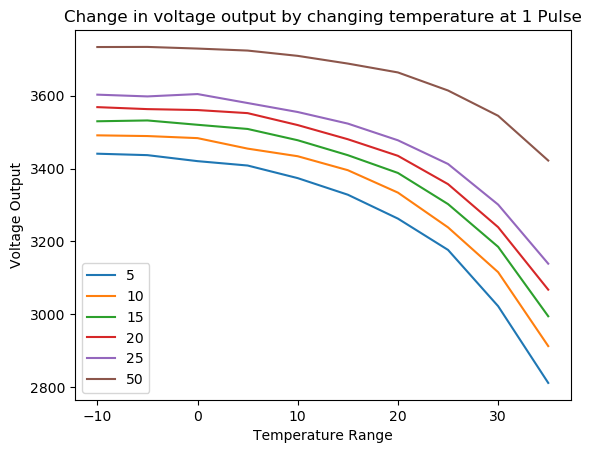

In [21]:
import numpy as np
from matplotlib import pyplot as plt

Temp_Range = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35 ]
Dose_Range = [1, 5, 10, 15]
Bias_Range = [5, 10, 15, 20, 25, 50]

testdata = np.load("./datarun1.955724") 
tempdata = np.load("./temp_record_2024-02-21 16:34:3.955724")
y = testdata[:,0,0]
y2 = testdata[:,0,1]
y3 = testdata[:,0,2]
y4 = testdata[:,0,3]
y5 = testdata[:,0,4]
y6 = testdata[:,0,5]

x = Temp_Range
plt.plot(x,y)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.plot(x,y5)
plt.plot(x,y6)
plt.title("Change in voltage output by changing temperature at 1 Pulse")
plt.ylabel("Voltage Output")
plt.xlabel("Temperature Range")
plt.legend(Bias_Range)

#plt.plot(x,y)
